In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/trafic_data/yolov7/

/content/drive/MyDrive/trafic_data/yolov7


In [ ]:
# Reinstall PyTorch - only run for first time
!pip uninstall -y torch
!pip install torch torchvision torchaudio


Found existing installation: torch 2.4.1+cu121
Uninstalling torch-2.4.1+cu121:
  Successfully uninstalled torch-2.4.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 8.0 MB/s eta 0:00:

In [ ]:
import torch
model = torch.hub.load('WongKinYiu/yolov7', 'custom', path_or_model='yolov7.pt')


Using cache found in /root/.cache/torch/hub/WongKinYiu_yolov7_main


requirements: numpy<1.24.0,>=1.18.5 not found and is required by YOLOR, attempting auto-update...

requirements: 1 package updated per /root/.cache/torch/hub/WongKinYiu_yolov7_main/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



/root/.cache/torch/hub/WongKinYiu_yolov7_main/hubconf.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path_or_model, map_location=torch.device('cpu')

Adding autoShape... 


In [25]:
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython.display import display, HTML
import subprocess
import shutil
import math

for i in range(4,7):
  print()
  print("-------------------------------------------------------------- SET-" + str(i) +" -------------------------------------------------------------")
  print()
  def load_image(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None

    try:
        image = Image.open(image_path)
        return image
    except Exception as e:
        print(f"Failed to load image {image_path}: {e}")
        return None

  dataset_path = '/content/drive/MyDrive/datapath/set'
  dataset_path = dataset_path + str(i)
  lane_images = {
      'lane_1': os.path.join(dataset_path, 'lane_1.jpg'),
      'lane_2': os.path.join(dataset_path, 'lane_2.jpg'),
      'lane_3': os.path.join(dataset_path, 'lane_3.jpg'),
      'lane_4': os.path.join(dataset_path, 'lane_4.jpg')
  }

  def detect_vehicles(image_path):
      img = load_image(image_path)
      if img is None:
          return 0, False, 0, []

      results = model(img)

      vehicle_weights = {'ambulance': 100, 'army vehicle': 5, 'auto rickshaw': 3, 'bicycle': 1, 'bus': 6, 'car': 4,
                        'garbagevan': 5, 'human hauler': 1, 'minibus': 5, 'minivan': 5, 'motorbike': 1, 'pickup': 5,
                        'policecar': 100, 'rickshaw': 3, 'scooter': 2, 'suv': 4, 'taxi': 4,
                        'three wheelers -CNG-': 3, 'truck': 8, 'van': 5, 'wheelbarrow': 3, 'fireengine': 100}

      emergency_vehicles = ['ambulance', 'fireengine', 'policecar']
      lane_weights = 0
      count = 0
      emergency_present = False
      detected_vehicles = []

      for obj in results.xyxy[0]:
          class_id = int(obj[5])
          class_name = results.names[class_id]

          if class_name in vehicle_weights:
              detected_vehicles.append(class_name)
              if class_name in emergency_vehicles:
                  emergency_present = True
              else:
                  lane_weights += vehicle_weights[class_name]
                  count += 1

      return lane_weights, emergency_present, count, detected_vehicles



  def detect_all_lanes(lane_images):
      lane_weights = {}
      emergency_detected = False
      counts = {}
      detected_vehicles_per_lane = {}

      available_lanes = []
      for lane, image_path in lane_images.items():
          if load_image(image_path):
              available_lanes.append(lane)
              weight, emergency, count, detected_vehicles = detect_vehicles(image_path)
              lane_weights[lane] = weight
              counts[lane] = count
              item_count = {}

              for item in detected_vehicles:
                  if item in item_count:
                      item_count[item] += 1
                  else:
                      item_count[item] = 1
              detected_vehicles_per_lane[lane] = item_count

              if emergency:
                  emergency_detected = True
                  prioritized_lane = lane
                  break

      if len(available_lanes) < 4:
          missing_lanes = [lane for lane in ['lane_1', 'lane_2', 'lane_3', 'lane_4'] if lane not in available_lanes]
          if len(missing_lanes) == 1:
              present_weights = [lane_weights[lane] for lane in available_lanes]
              median_weight = np.median(present_weights)
              predicted_time = sum(present_weights) - 2 * median_weight
              lane_weights[missing_lanes[0]] = predicted_time

      return lane_weights, emergency_detected, counts, prioritized_lane if emergency_detected else None, detected_vehicles_per_lane

      def traffic_control(lane_weights, emergency_detected, emergency_lane):
        if emergency_detected:
          return emergency_lane, 40

      return lane_weights

  def handle_image_failure():
      default_cycle = ['lane_1', 'lane_2', 'lane_3', 'lane_4']
      return default_cycle

  def load_image(image_path):
      if not os.path.exists(image_path):
          print(f"Image not found: {image_path}")
          return None

      try:
          image = Image.open(image_path)
          return image
      except Exception as e:
          print(f"Failed to load image {image_path}: {e}")
          return None




  def run_detection():
      project_path = '/content/drive/MyDrive/trafic_output'
      detected_path = os.path.join(project_path, 'detected')

      if os.path.exists(detected_path):
          shutil.rmtree(detected_path)

      command = [
          'python', 'detect.py',
          '--weights', 'runs/train/exp15/weights/best.pt',
          '--source', dataset_path,
          '--img', '640',
          '--conf', '0.25',
          '--device', '0',
          '--project', project_path,
          '--name', 'detected',
          '--exist-ok'
      ]

      subprocess.run(command, check=True)

  def display_images(lane_images, detection=False):
      plt.figure(figsize=(12, 8))
      for i, (lane, image_path) in enumerate(lane_images.items(), start=1):
          img = load_image(image_path)
          if img:
              plt.subplot(2, 2, i)
              plt.imshow(img)
              plt.title(f'{lane} - {"Detected" if detection else "Original"}')
              plt.axis('off')
      plt.tight_layout()
      plt.show()

  def color_text(text, color, bold=False):
      style = f"color: {color};"
      if bold:
          style += "font-weight: bold;"
      return f'<span style="{style}">{text}</span>'

  def traffic_cycle(lane_weights, emergency_detected, emergency_lane, failure=False):
      time_list = []
      cumulative_time_list = []
      lane_1_list = []
      lane_2_list = []
      lane_3_list = []
      lane_4_list = []
      lane_weights_list = []

      time_dict = {}

      total_time = 0
      original_weights = lane_weights.copy()

      if failure:
          cycle = handle_image_failure()
          for lane in cycle:
              time_list.append(40)
              total_time += 40
              cumulative_time_list.append(f"{math.ceil(total_time)}")
              for l in [lane_1_list, lane_2_list, lane_3_list, lane_4_list]:
                  l.append(color_text('Red', 'red'))
              if lane == 'lane_1':
                  lane_1_list[-1] = color_text('Green', 'green')
              elif lane == 'lane_2':
                  lane_2_list[-1] = color_text('Green', 'green')
              elif lane == 'lane_3':
                  lane_3_list[-1] = color_text('Green', 'green')
              elif lane == 'lane_4':
                  lane_4_list[-1] = color_text('Green', 'green')
              lane_weights_list.append(original_weights[lane])
      else:
          total_weight = sum(weight for lane, weight in lane_weights.items() if weight > 0)
          for _ in range(4):
              max_lane = max((lane for lane in lane_weights if lane_weights[lane] > 0), key=lambda l: lane_weights[l], default=None)
              if max_lane:
                  time = min((lane_weights[max_lane])* 0.35, 40)
                  time_list.append(f"{round(time)}")
                  total_time += time
                  time_dict[max_lane] = time
                  cumulative_time_list.append(f"{round(total_time)}")

                  lane_1_list.append(color_text('Green', 'green') if max_lane == 'lane_1' else color_text('Red', 'red'))
                  lane_2_list.append(color_text('Green', 'green') if max_lane == 'lane_2' else color_text('Red', 'red'))
                  lane_3_list.append(color_text('Green', 'green') if max_lane == 'lane_3' else color_text('Red', 'red'))
                  lane_4_list.append(color_text('Green', 'green') if max_lane == 'lane_4' else color_text('Red', 'red'))
                  lane_weights_list.append(original_weights[max_lane])
                  lane_weights[max_lane] = 0
                  if emergency_detected:
                      break

          missing_lanes = [lane for lane in ['lane_1', 'lane_2', 'lane_3', 'lane_4'] if lane_weights.get(lane, 0) == 0]
          if missing_lanes:
              missing_lane = missing_lanes[0]
              present_weights = [weight for lane, weight in lane_weights.items() if lane in lane_weights and weight > 0]
              if len(present_weights) > 0:
                  median_weight = np.median(present_weights)
                  predicted_time = sum(present_weights) - 2 * median_weight
                  predicted_time = max(predicted_time, 0)
                  time_list.append(f"{predicted_time:.2f}")
                  total_time += predicted_time
                  cumulative_time_list.append(f"{total_time:.2f}")

                  if missing_lane == 'lane_1':
                      lane_1_list.append(color_text('Green', 'green'))
                  elif missing_lane == 'lane_2':
                      lane_2_list.append(color_text('Green', 'green'))
                  elif missing_lane == 'lane_3':
                      lane_3_list.append(color_text('Green', 'green'))
                  elif missing_lane == 'lane_4':
                      lane_4_list.append(color_text('Green', 'green'))

                  lane_weights_list.append(original_weights[missing_lane])
              else:
                  time_list.append('')
                  cumulative_time_list.append('')
                  lane_1_list.append('')
                  lane_2_list.append('')
                  lane_3_list.append('')
                  lane_4_list.append('')
                  lane_weights_list.append('')

      time_list.append('')
      cumulative_time_list.append(color_text(f"{round(total_time)}", 'orange', bold=True))
      lane_1_list.append('')
      lane_2_list.append('')
      lane_3_list.append('')
      lane_4_list.append('Total')
      lane_weights_list.append('')

      df = pd.DataFrame({
          'Lane Weights': lane_weights_list,
          'Time (seconds)': time_list,
          'Lane 1': lane_1_list,
          'Lane 2': lane_2_list,
          'Lane 3': lane_3_list,
          'Lane 4': lane_4_list,
          'Cumulative Time': cumulative_time_list
      })

      display(HTML(df.to_html(escape=False, index=False)))
      return time_dict

  run_detection()

  detected_images = {
      'lane_1': '/content/drive/MyDrive/trafic_output/detected/lane_1.jpg',
      'lane_2': '/content/drive/MyDrive/trafic_output/detected/lane_2.jpg',
      'lane_3': '/content/drive/MyDrive/trafic_output/detected/lane_3.jpg',
      'lane_4': '/content/drive/MyDrive/trafic_output/detected/lane_4.jpg'
  }

  display_images(detected_images, detection=True)

  lane_weights, emergency_detected, counts, emergency_lane, detected_vehicles_per_lane = detect_all_lanes(lane_images)
  time_dict = traffic_cycle(lane_weights, emergency_detected, emergency_lane)




Output hidden; open in https://colab.research.google.com to view.

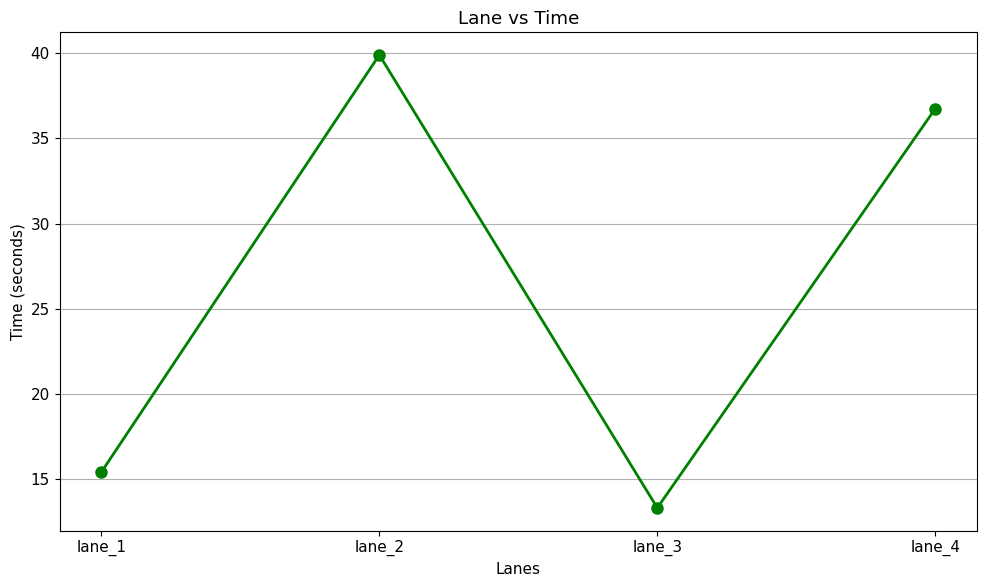

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

time_dict=dict(sorted(time_dict.items()))


lanes = list(time_dict.keys())
times = list(time_dict.values())

plt.figure(figsize=(10, 6))
plt.plot(lanes, times, color='green', marker='o', linestyle='-', linewidth=2, markersize=8)

plt.xlabel('Lanes')
plt.ylabel('Time (seconds)')
plt.title('Lane vs Time')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()
